# Lecture 15 : GPU Hello World and Sum

## We will learn to program Nvidia GPUs using CUDA (Compute Unified Device Architecture).  

## Google Colab gives free access (be responsible!) to a Nvidia T4 GPU (Turing Class).  

## Here is a picture of a Turing Class GPU (not T4).

## Such a GPU is capaple of performing thousands of calculations simultaneously!

## The TU102 shown here has 72 SMs (stream multiprocessors).  

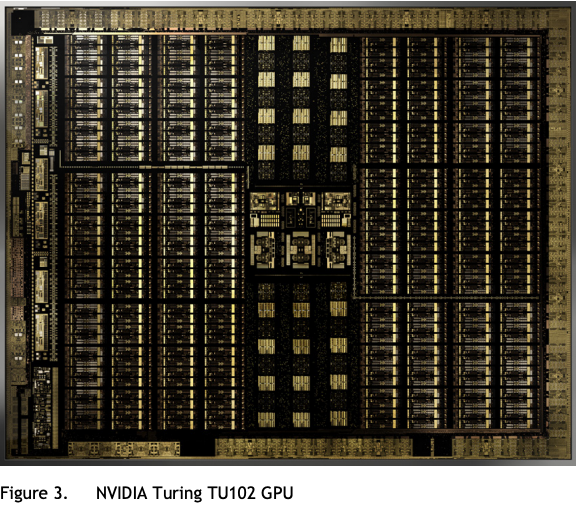

## The Nvidia T4 is a version of the TU104 GPU (shown below) that has 40 SMs.  

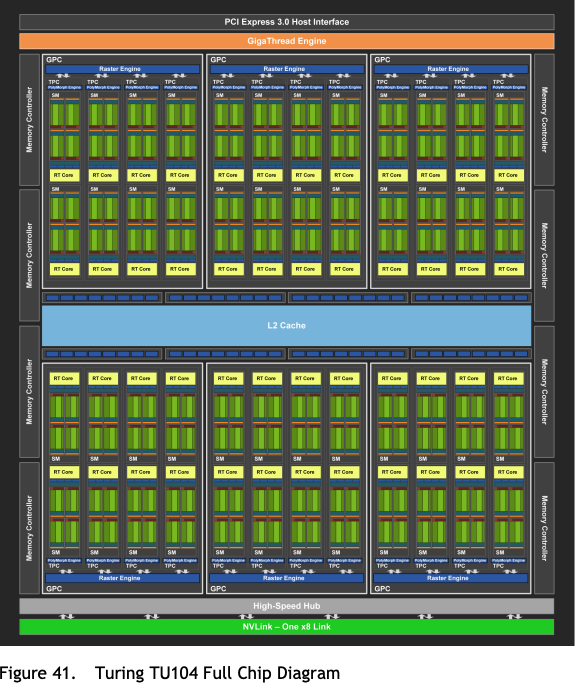

## One of the 40 SMs on the T4 is shown below.  

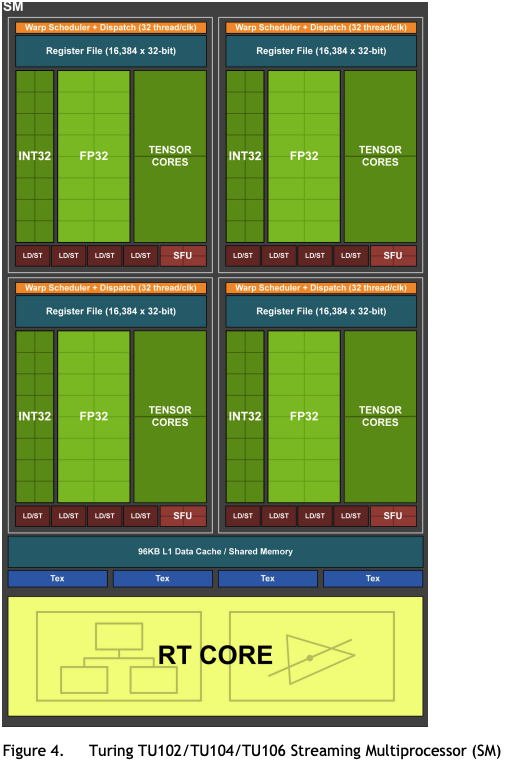

## Here is our first CUDA program : Hello World!

## Note that a CUDA source file ends with *.cu* and we must include *cuda.h*

## A CUDA kernel such as the helloKernel shown below is executed by each thread.  

## A CUDA kernel is a similar to a OpenMP parallel region but there are some differences.

## We use the command given in line 26 to launch the kernel.

## The parameters between the <<< and >>> are called *launch parameters*.

## The first launch parameter is the number of thread blocks.    

## The second launch parameter is the number of threads per thread block.  

## Note that for the examples in this lecture we are specifying only a single thread block.  That means that all of our threads will run on a single SM.  This is a big limitation as it means we will only use 1/40 of the full computational power of the T4 GPU.  

## Later we will learn how to use multiple thread blocks to unleash the full power of the GPU.

## The **cudaDeviceSynchronize();** line forces the program to wait until all threads finish executing the kernel before ending.  Without this line, the printf statements will not be displayed.

## To compile and run the Hello World program on a T4 GPU, select **Change runtime type** from the **Runtime** menu and change the runtime type to **T4 GPU**.  

## **As soon as you are finished compiling and running your GPU code, disconnect the GPU runtime.**

## **Disconnecting the GPU runtime when you are not using the T4 GPU is critical since you only have limited free access to a T4 GPU runtime on Google Colab.**

In [ ]:
%%writefile gpu_hello.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

__global__ void helloKernel() {

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    printf (" Hello World! from thread %d of %d\n",thread_num,num_threads);
}

int main(int argc, char** argv) {

    // get num_threads from the command line
    if (argc < 2) {
        printf ("Command usage : %s %s\n",argv[0],"num_threads");
        return 1;
    }

    int num_threads = atoi(argv[1]);

    printf ("num_threads = %d\n",num_threads);

    helloKernel <<< 1, num_threads >>> ();
    cudaDeviceSynchronize();
}

Writing gpu_hello.cu


## To compile a CUDA source file we use *nvcc* instead of our normal *gcc*.

In [ ]:
!nvcc -arch=sm_75 -o gpu_hello gpu_hello.cu

## Run the program with 32 threads and with 128 threads.  What do you observe?

## Threads are grouped into warps of size 32.  

## Threads in a particular warp execute the same instruction simultaneously but on different data.  

## This type of parallelism is called SIMD (same instruction multiple data).

In [ ]:
!./gpu_hello 32

num_threads = 32
 Hello World! from thread 0 of 32
 Hello World! from thread 1 of 32
 Hello World! from thread 2 of 32
 Hello World! from thread 3 of 32
 Hello World! from thread 4 of 32
 Hello World! from thread 5 of 32
 Hello World! from thread 6 of 32
 Hello World! from thread 7 of 32
 Hello World! from thread 8 of 32
 Hello World! from thread 9 of 32
 Hello World! from thread 10 of 32
 Hello World! from thread 11 of 32
 Hello World! from thread 12 of 32
 Hello World! from thread 13 of 32
 Hello World! from thread 14 of 32
 Hello World! from thread 15 of 32
 Hello World! from thread 16 of 32
 Hello World! from thread 17 of 32
 Hello World! from thread 18 of 32
 Hello World! from thread 19 of 32
 Hello World! from thread 20 of 32
 Hello World! from thread 21 of 32
 Hello World! from thread 22 of 32
 Hello World! from thread 23 of 32
 Hello World! from thread 24 of 32
 Hello World! from thread 25 of 32
 Hello World! from thread 26 of 32
 Hello World! from thread 27 of 32
 Hello World!

## In the next example we have 128 threads which are broken down into 4 warps.
## The first warp is threads 0-31, the second warp is threads 32-63 and so on.
## The order in which warps execute is not deterministic.

In [ ]:
!./gpu_hello 128

num_threads = 128
 Hello World! from thread 64 of 128
 Hello World! from thread 65 of 128
 Hello World! from thread 66 of 128
 Hello World! from thread 67 of 128
 Hello World! from thread 68 of 128
 Hello World! from thread 69 of 128
 Hello World! from thread 70 of 128
 Hello World! from thread 71 of 128
 Hello World! from thread 72 of 128
 Hello World! from thread 73 of 128
 Hello World! from thread 74 of 128
 Hello World! from thread 75 of 128
 Hello World! from thread 76 of 128
 Hello World! from thread 77 of 128
 Hello World! from thread 78 of 128
 Hello World! from thread 79 of 128
 Hello World! from thread 80 of 128
 Hello World! from thread 81 of 128
 Hello World! from thread 82 of 128
 Hello World! from thread 83 of 128
 Hello World! from thread 84 of 128
 Hello World! from thread 85 of 128
 Hello World! from thread 86 of 128
 Hello World! from thread 87 of 128
 Hello World! from thread 88 of 128
 Hello World! from thread 89 of 128
 Hello World! from thread 90 of 128
 Hello Wor

# **Do not forget to disconnect the GPU runtime now.**

## Next let's write a CUDA program for computing the sum of the first $N$ integers.

## Recall that Gauss showed that
$$\displaystyle\sum_{i=1}^{N} i = \displaystyle\frac{N(N+1)}{2}$$

## For our first version we will just have each thread compute the entire sum and print out the result.  Note that the kernel function now has an argument.

## As in OpenMP, variables defined in a CUDA kernel (including arguments) are private variables (one for each thread) by default.  

## CUDA kernels always have a *void* return type so outputs must be returned through pointers.  

## Discussion: How would you change the kernel so that each thread only calculates an approximately equal share of the sum?

## Note: Unlike OpenMP, CUDA does not have built in support for scheduling *for loop iterations* across threads.

## Hint: Suppose there are only two threads.  How would you write the for loop so that thread 0 adds up the odd numbers 1+3+5+... and thread 1 adds up the even numbers 2+4+6+...?

In [ ]:
%%writefile gpu_sum_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long uint64;

__global__ void sumKernel(uint64 N) {

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    uint64 sum = 0;
    for (uint64 i = 1; i <= N;i++) {
        sum += i;
    }

    printf (" on thread %d of %d, sum = %llu\n",thread_num,num_threads,sum);
}

int main(int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Writing gpu_sum_v1.cu


In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v1 gpu_sum_v1.cu

In [ ]:
!./gpu_sum_v1 1000 2

num_threads = 2
N*(N+1)/2 = 500500
 on thread 0 of 2, sum = 500500
 on thread 1 of 2, sum = 500500


# **Do not forget to disconnect the GPU runtime now.**

## Here is version 2 of the kernel where each thread calculates an approximately equal share of the sum and prints the partial result.

## Discussion: In order for the threads to communicate partial results we will need to use what type of variable?

In [ ]:
%%writefile gpu_sum_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long uint64;

__global__ void sumKernel(uint64 N) {

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    uint64 sum = 0;
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        sum += i;
    }

    printf (" on thread %d of %d, sum = %llu\n",thread_num,num_threads,sum);
}

int main(int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Overwriting gpu_sum_v2.cu


In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v2 gpu_sum_v2.cu

In [ ]:
!./gpu_sum_v2 1000 2

num_threads = 2
N*(N+1)/2 = 500500
 on thread 0 of 2, sum = 250000
 on thread 1 of 2, sum = 250500


# **Do not forget to disconnect the GPU runtime now.**

## Here is version 3 of the kernel where we use a shared variable sum.  

## Note that we designate the thread with thread_num equal to 0 as a special thread.  Note that only the thread 0 initializes the shared variable and prints the final result.  

## When we run version 3 we get the incorrect answer.  

## Discussion : Describe the problem with the kernel and a potential solution.  

In [ ]:
%%writefile gpu_sum_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long uint64;

__global__ void sumKernel(uint64 N) {

    __shared__ uint64 sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // thread 0 initializes sum to 0
    if (thread_num == 0) {
        sum = 0;
    }

    // calculate the sum
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        sum += i;
    }

    // thread 0 prints the sum
    if (thread_num == 0) {
        printf (" sum = %llu\n",sum);
    }
}

int main(int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Overwriting gpu_sum_v3.cu


In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v3 gpu_sum_v3.cu

In [ ]:
!./gpu_sum_v3 1000 4

num_threads = 4
N*(N+1)/2 = 500500
 sum = 124750


# **Do not forget to disconnect the GPU runtime now.**

## Here is version 4 of the kernel that uses an atomic add instruction to avoid the read-write race condition present in the previous version.

## Note that this version of the kernel takes a while to run on a modest N of 100 million with 32 threads.  Even though we are only using a small part of the GPU this seems very slow.  

## Discussion : Describe the problem with the kernel and a potential solution.  

## Hint: the atomic add instruction is serving the same purpose as what OpenMP construct?  What do we know about that OpenMP construct?

In [ ]:
%%writefile gpu_sum_v4.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    __shared__ uint64 sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // initialize sum to 0
    if (thread_num == 0) {
        sum = 0;
    }

    // calculate the sum
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        atomicAdd(&sum,i);
    }

    // thread 0 prints the sum
    if (thread_num == 0) {
        printf (" sum = %llu\n",sum);
    }
}

int main(int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Writing gpu_sum_v4.cu


In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v4 gpu_sum_v4.cu

In [ ]:
!time ./gpu_sum_v4 100000000 32

num_threads = 32
N*(N+1)/2 = 5000000050000000
 sum = 5000000050000000

real	0m10.015s
user	0m9.767s
sys	0m0.143s


# **Do not forget to disconnect the GPU runtime now.**

## Here is version 5 of the kernel that uses a thread version of the sum variable to pull the atomicAdd outside of the for loop.  Note in particular that each thread only executes the atomicAdd one time.  

## Note that this version of the kernel is much faster than the previous.  In fact it can now calculate a larger sum (N equal to a billion) in around one second.

## Try running the kernel with 64 threads instead of 32 threads.  What do you observe?

## Discussion : Describe the problem with the kernel and a potential solution.

## Hints : What would happen if thread 32 finishes updating the shared sum variable with its partial sum before thread 0 initializes sum to 0?  What would happen if thread 0 prints the final result before thread 32 finishes updating the shared sum variable with its partial sum?

In [ ]:
%%writefile gpu_sum_v5.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    __shared__ uint64 sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // initialize sum to 0
    if (thread_num == 0) {
        sum = 0;
    }

    // calculate the sum
    uint64 thread_sum = 0;
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        thread_sum += i;
    }
    atomicAdd(&sum,thread_sum);

    // thread 0 prints the sum
    if (thread_num == 0) {
        printf (" sum = %llu\n",sum);
    }
}

int main(int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Writing gpu_sum_v5.cu


In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v5 gpu_sum_v5.cu

In [ ]:
!time ./gpu_sum_v5 1000000000 32

num_threads = 32
N*(N+1)/2 = 500000000500000000
 sum = 500000000500000000

real	0m1.094s
user	0m0.804s
sys	0m0.152s


In [ ]:
!time ./gpu_sum_v5 1000000000 128

num_threads = 128
N*(N+1)/2 = 500000000500000000
 sum = 496093750000000000

real	0m0.457s
user	0m0.312s
sys	0m0.132s


# **Do not forget to disconnect the GPU runtime now.**

## Here is version 6 of the kernel that uses two barriers to fix the bugs in kernel 5.  
## The GPU function for placing a barrier in the kernel is **__syncthreads();**.
## A barrier is a line of code that all threads (in a particular thread block) must get to before any thread is allowed to continue.  
## The first barrier ensures that thread 0 initializes the sum variable to 0 before other threads are allowed to start updating the shared sum variable with the partial sums.  
## The second barrier ensures that all threads have finished adding their partial sums to the shared sum variable before thread 0 prints the final result.  

In [ ]:
%%writefile gpu_sum_v6.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    __shared__ uint64 sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // initialize sum to 0
    if (thread_num == 0) {
        sum = 0;
    }
    __syncthreads();

    // calculate the sum
    uint64 thread_sum = 0;
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        thread_sum += i;
    }
    atomicAdd(&sum,thread_sum);
    __syncthreads();

    // thread 0 prints the sum
    if (thread_num == 0) {
        printf (" sum = %llu\n",sum);
    }
}

int main(int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }

    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);

    printf ("num_threads = %d\n",num_threads);
    printf ("N*(N+1)/2 = %llu\n",(N/2)*(N+1));

    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

}

Writing gpu_sum_v6.cu


In [ ]:
!nvcc -arch=sm_75 -o gpu_sum_v6 gpu_sum_v6.cu

In [ ]:
!time ./gpu_sum_v6 1000000000 128

num_threads = 128
N*(N+1)/2 = 500000000500000000
 sum = 500000000500000000

real	0m0.481s
user	0m0.340s
sys	0m0.119s


# **Do not forget to disconnect the GPU runtime now.**
# **Do not forget to switch back to a CPU runtime now.**